Author: Licun Liu  
Student Id: 30901235  
Start date: 8/01/2021

# 1. Working with RDD

## 1.1 Data Loading 
### 1.1.1 SparkContext and SparkSession <a class="anchor" name="one"></a>

In [1]:
# Import SparkConf class into program
from pyspark import SparkConf

# local[*]: run Spark in local mode with as many working processors as logical cores on your machine
# If we want Spark to run locally with 'k' worker threads, we can specify as "local[k]".
master = "local[*]"
# The `appName` field is a name to be shown on the Spark cluster UI page
app_name = "Assignment 1"
# Setup configuration parameters for Spark
spark_conf = SparkConf().setMaster(master).setAppName(app_name).set("spark.sql.session.timeZone", "Australia/Melbourne")

# Import SparkContext and SparkSession classes
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL

# Method 1: Using SparkSession
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')

# # Method 2: Getting or instantiating a SparkContext
# sc = SparkContext.getOrCreate(spark_conf)
# sc.setLogLevel('ERROR')

### 1.1.2 Read into RDD

In [2]:
# Read pedestrian count CSV into rdd_1
rdd_1 = sc.textFile('Pedestrian_Counting_System_-_Monthly__counts_per_hour.csv')

In [3]:
# Read the sensor location CSV into rdd_2
rdd_2 = sc.textFile('Pedestrian_Counting_System_-_Sensor_Locations.csv')

#### 1.1.2 Remove the header and Parse into a Row object

In [4]:
# Library Requried
from pyspark.sql import SparkSession, Row
from datetime import timedelta, datetime

In [5]:
# Remove the header
header_1 = rdd_1.first()
rdd_1 = rdd_1.filter(lambda x: x != header_1)

header_2 = rdd_2.first()
rdd_2 = rdd_2.filter(lambda x: x != header_2)

##### (1) Deal with the the RDD for pedestrian count CSV

In [6]:
# Deal with the the RDD for pedestrian count CSV
def parseRecord_rdd_1(line):
    # Split line separated by comma
    array_line = line.split(',')
    # Return a Row
    return Row(ID=int(array_line[0]), Date_Time = datetime.strptime(array_line[1], '%m/%d/%Y %I:%M:%S %p'),Year = int(array_line[2])
             ,Month=str(array_line[3]),Mdate=int(array_line[4]),Day = str(array_line[5]),Time= int(array_line[6]), 
               Sensor_ID = int(array_line[7]),Sensor_Name = str(array_line[8]),Hourly_Counts = int(array_line[9]))

map_rdd_1 = rdd_1.map(parseRecord_rdd_1)


##### (2) Deal with the the RDD for sensor location CSV

In [7]:
# Deal with the the RDD for sensor location CSV
def parseRecord_rdd_2(line):
    # Split line separated by comma
    array_line = line.split(',')
    # Return a Row
    return Row(sensor_id=int(array_line[0]), sensor_description = str(array_line[1]),sensor_name = str(array_line[2])
             ,installation_date = datetime.strptime(array_line[3], '%Y/%m/%d'),status=str(array_line[4]),note = str(array_line[5]),
               direction_1= str(array_line[6]), direction_2 = str(array_line[7]),latitude = float(array_line[8]),
               longitude = float(array_line[9]),location=tuple((float(array_line[10][2:]),float(array_line[11][1:-2]))))

map_rdd_2 = rdd_2.map(parseRecord_rdd_2)

### 1.1.3 Show the RDD

#### 1.1.3.a Show the RDD for pedestrian count CSV

In [8]:
print("As for pedestrian count CSV ")

# Show the number of column
print(f"####### The number of columns: {len(map_rdd_1.take(1)[0])}")

# Show the total number of records
print(f"####### The total number of records is: {map_rdd_1.count()}")


As for pedestrian count CSV 
####### The number of columns: 10
####### The total number of records is: 3435106


In [9]:
# Display the first 2 records
map_rdd_1.take(2)

[Row(ID=2887628, Date_Time=datetime.datetime(2019, 11, 1, 17, 0), Year=2019, Month='November', Mdate=1, Day='Friday', Time=17, Sensor_ID=34, Sensor_Name='Flinders St-Spark La', Hourly_Counts=300),
 Row(ID=2887629, Date_Time=datetime.datetime(2019, 11, 1, 17, 0), Year=2019, Month='November', Mdate=1, Day='Friday', Time=17, Sensor_ID=39, Sensor_Name='Alfred Place', Hourly_Counts=604)]

#### 1.1.3.b Show the RDD for sensor location CSV

In [10]:
print("As for sensor location CSV ")

# Show the number of column 
print(f"####### The number of columns: {len(map_rdd_2.take(1)[0])}")

# Show the total number of records
print(f"####### The total number of records is: {map_rdd_2.count()}")

As for sensor location CSV 
####### The number of columns: 11
####### The total number of records is: 72


In [11]:
# Display the first 2 records
map_rdd_2.take(2)

[Row(sensor_id=59, sensor_description='Building 80 RMIT', sensor_name='RMIT_T', installation_date=datetime.datetime(2019, 2, 13, 0, 0), status='A', note='', direction_1='North', direction_2='South', latitude=-37.80825648, longitude=144.96304859, location=(-37.80825648, 144.96304859)),
 Row(sensor_id=20, sensor_description='Chinatown-Lt Bourke St (South)', sensor_name='LtB170_T', installation_date=datetime.datetime(2013, 9, 6, 0, 0), status='A', note='', direction_1='East', direction_2='West', latitude=-37.81172913, longitude=144.9682466, location=(-37.81172913, 144.9682466))]

## 1.2 Analysis

### 1.2.1 Perform range partitioning

In [12]:
# Find the max values in “Hourly_Counts” column
result_max = map_rdd_1.max(key=lambda x: x[9]) # Get max by value in index 9

# Using the max values in “Hourly_Counts” to defined the number of partitions
no_of_partitions= round(result_max[9]/1000)

#Find the size of the elements in RDD
chunk_size = map_rdd_1.count() / no_of_partitions
#Define a range of values by key to distribute across partitions
#We are defining the range i.e. keys from 0-999 to fall in first partition, 1000-1999 in second partition and so on

# Initial some value
i = 0
range_arr = []

# Defining the range using the a while loop
while i < no_of_partitions:
    a_list = [(1000*i),(999+1000*i)]
    range_arr.append(a_list)
    i = i+1

# Define the range function
def range_function(key):
    for index,item in enumerate(range_arr):
        if key >=item[0] and key <=item[1]:
            return index

In [13]:
# Covert it to a tuple, and use Hourly_Counts values as the key.
map_rdd_1_tuple = map_rdd_1.map(lambda r: (r[9], r))

In [14]:
# range partition
range_partitioned_rdd = map_rdd_1_tuple.partitionBy(no_of_partitions, range_function)

In [15]:
from pyspark.rdd import RDD

#A Function to print the data items in each RDD
#Same function is used to print out the data items of a DataFrame later
def print_partitions(data):
    # Get the number of the partitions
    numPartitions = data.getNumPartitions()
    # Get the number of records in each partitions
    record = range_partitioned_rdd.glom().map(len).collect()
    # Print out the number of partitions
    print(f"####### NUMBER OF PARTITIONS: {numPartitions}")
    
    i = 0 # Accumulator
    # Using a while loop to display the number of records in each partitions.
    while i < numPartitions:
        print(f"Partition" + str(i) + ": " + str(record[i]) + " records")
        i = i + 1

In [16]:
# Remove key extracted previously
range_partitioned_rdd_1 = range_partitioned_rdd.map(lambda r: r[1])

In [17]:
# Call the print function to display the number of partitions and the number of records in each partition
print_partitions(range_partitioned_rdd_1)

####### NUMBER OF PARTITIONS: 16
Partition0: 2795353 records
Partition1: 388811 records
Partition2: 168802 records
Partition3: 61993 records
Partition4: 15829 records
Partition5: 3779 records
Partition6: 337 records
Partition7: 110 records
Partition8: 44 records
Partition9: 29 records
Partition10: 8 records
Partition11: 8 records
Partition12: 1 records
Partition13: 0 records
Partition14: 1 records
Partition15: 1 records


### 1.2.2 Yearly total pedestrian counts and the average daily pedestrian counts

In [18]:
# Count the number of day in each year
rdd_count_day = range_partitioned_rdd_1.map(lambda x: (x[2], str(x[2])+str(x[3])+str(x[4]))).groupByKey().mapValues(lambda vals: len(set(vals)))

# Calculate the total pedestrian count
rdd_hour_sum = range_partitioned_rdd_1.map(lambda x: ((x[2]),int(x[9]))).reduceByKey(lambda x,y:x+y).map(lambda x: (x[0],x[1]))

# Join the number of day in each year and the total pedestrian count
join_rdd = rdd_count_day.join(rdd_hour_sum).sortByKey()

# Display the result
rdd_result = join_rdd.map(lambda x: (x[0],x[1][1],x[1][1]/x[1][0]))       #.sortByKey()
rdd_result.collect()

[(2009, 62650110, 255714.73469387754),
 (2010, 93459437, 256053.25205479452),
 (2011, 90571965, 248142.3698630137),
 (2012, 102215521, 279277.37978142075),
 (2013, 117389820, 321615.94520547945),
 (2014, 169500386, 464384.6191780822),
 (2015, 209099687, 572875.8547945205),
 (2016, 228757880, 625021.5300546448),
 (2017, 216586414, 593387.4356164384),
 (2018, 261909318, 717559.7753424657),
 (2019, 266411675, 729895.0),
 (2020, 107788571, 321756.92835820897)]

### 1.2.3 Top-5 sensors

In [53]:
# Extact relevant data from rdd_1 (sensor id, datetime, hourly count)
rdd_1_select = range_partitioned_rdd_1.map(lambda x: (x[7],(x[1],x[9])))

# Extact relevant data from rdd_2 (sensor id and sensor description)
rdd_2_select = map_rdd_2.map(lambda x: (x[0],x[1]))

# Count the number of hour for each sensor
rdd_count = rdd_1_select.map(lambda x: (x[0],x[1][0])).groupByKey().mapValues(lambda vals: len((vals)))

# Calculate the total pedestrian count for each sensor
rdd_sum = rdd_1_select.map(lambda x: ((x[0]),int(x[1][1]))).reduceByKey(lambda x,y:x+y).map(lambda x: (x[0],x[1]))

#Join rdd_count and rdd_sum
rdd_join_final_1 = rdd_count.join(rdd_sum)
#Join the result and sensor description
rdd_join_final = rdd_join_final_1.join(rdd_2_select).sortByKey()

# Calculate average hourly count and select some columns as a new RDD
rdd_finish = rdd_join_final.map(lambda x: (x[0],x[1][1],x[1][0][1]/x[1][0][0])).sortBy(lambda x: -x[2])     # Sort by descending  

# Print out top-5 sensors with the highest average pedestrian counts
rdd_finish.take(5)

[(38, 'Flinders St-Swanston St (West)', 2448.7808288981996),
 (60, 'Flinders La - Swanston St (West) Temporary', 1600.0702749890877),
 (41, 'Flinders La-Swanston St (West)', 1454.7942818958522),
 (22, 'Flinders St-Elizabeth St (East)', 1433.3714966970253),
 (4, 'Town Hall (West)', 1419.5947524005198)]

# 2. Working with DataFrames

## 2.1 Data Loading

In [20]:
# Library required
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.functions import col
from pyspark.sql import functions as F

#### 2.1.1 Define the data schema

In [21]:
# Define the data schema for pedestrian count CSV files
schema_rdd_1 = StructType([StructField("ID",IntegerType(),True),
                     StructField("Date_Time",StringType(),True),
                      StructField("Year",IntegerType(),True),
                       StructField("Month",StringType(),True),
                        StructField("Mdate",IntegerType(),True),
                         StructField("Day",StringType(),True),
                          StructField("Time",IntegerType(),True),
                           StructField("Sensor_ID",IntegerType(),True),
                            StructField("Sensor_Name",StringType(),True),
                             StructField("Hourly_Counts",IntegerType(),True)])

# Define the data schema for the sensor location file
schema_rdd_2 = StructType([StructField("sensor_id",IntegerType(),True),
                     StructField("sensor_description",StringType(),True),
                      StructField("sensor_name",StringType(),True),
                       StructField("installation_date",StringType(),True),
                        StructField("status",StringType(),True),
                         StructField("note",StringType(),True),
                          StructField("direction_1",StringType(),True),
                           StructField("direction_2",StringType(),True),
                            StructField("latitude",FloatType(),True),
                             StructField("longitude",FloatType(),True),
                              StructField("location",StringType(),True)                          ])

#### 2.1.2 Load the CSV file into dataframe

In [22]:
# Load the pedestrian count CSV file into a dataframe
df1 = spark.read.csv('Pedestrian_Counting_System_-_Monthly__counts_per_hour.csv',schema=schema_rdd_1,header=True)

# Load the sensor location CSV file into another dataframe
df2 = spark.read.csv('Pedestrian_Counting_System_-_Sensor_Locations.csv',schema=schema_rdd_2,header=True)

In [23]:
# Load the pedestrian count CSV file into a dataframe in another way
# df1 = spark.read.format('csv').options(header='true', inferSchema='true').load('Pedestrian_Counting_System_-_Monthly__counts_per_hour.csv')
# display(df1)

# Load the sensor location CSV file into another dataframe
# df2 = spark.read.format('csv').options(header='true', inferSchema='true').load('Pedestrian_Counting_System_-_Sensor_Locations.csv')
# display(df2)

#### 2.1.3.a Transform "Date_Time” column into date-time format.

In [24]:
# Display Date_Time before transformation 
df1.filter((col("ID") == 2853222) | (col("ID") == 2853223)).show()

+-------+--------------------+----+-------+-----+------+----+---------+-------------------+-------------+
|     ID|           Date_Time|Year|  Month|Mdate|   Day|Time|Sensor_ID|        Sensor_Name|Hourly_Counts|
+-------+--------------------+----+-------+-----+------+----+---------+-------------------+-------------+
|2853222|10/06/2019 02:00:...|2019|October|    6|Sunday|   2|       62|La Trobe St (North)|            0|
|2853223|10/06/2019 03:00:...|2019|October|    6|Sunday|   3|        4|   Town Hall (West)|           30|
+-------+--------------------+----+-------+-----+------+----+---------+-------------------+-------------+



In [25]:
# Transform it into date-time format.
df1 = df1.withColumn('Date_Time',F.to_timestamp('Date_Time', 'MM/dd/yyyy hh:mm:ss a'))

In [26]:
# Display Date_Time after transformation 
df1.filter((col("ID") == 2853222) | (col("ID") == 2853223)).show()

+-------+-------------------+----+-------+-----+------+----+---------+-------------------+-------------+
|     ID|          Date_Time|Year|  Month|Mdate|   Day|Time|Sensor_ID|        Sensor_Name|Hourly_Counts|
+-------+-------------------+----+-------+-----+------+----+---------+-------------------+-------------+
|2853222|2019-10-06 03:00:00|2019|October|    6|Sunday|   2|       62|La Trobe St (North)|            0|
|2853223|2019-10-06 03:00:00|2019|October|    6|Sunday|   3|        4|   Town Hall (West)|           30|
+-------+-------------------+----+-------+-----+------+----+---------+-------------------+-------------+



###### Describe what issues you have found and suggest what approaches could potentially remediate this issue:   
After we transform it into date-time format, the Date_time has changed in 2019-10-06. To be specific, 2 o'clock has changed to 3 o'clock.

This is because we have set the timezone in Melbourne/Australia.  
In Melbourne, we have winter time and summer time.    
In that day, winter time change to the summer time, so the 2 o'clock has changed to 3 o'clock.


#### 2.1.3.b Convert “installation_date” column into date format.

In [27]:
# Convert it into date format.
df2 = df2.withColumn('installation_date',F.to_date(F.unix_timestamp('installation_date', 'yyyy/MM/dd').cast('timestamp')))

#### 2.1.3.c Transform “location” column into a column of numeric arrays.

In [28]:
# Library Required
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf

In [29]:
# Delete the irrelevant characters in the values.
udf1 = udf(lambda x:x[1:-1],StringType())
df2 = df2.withColumn('location',udf1('location'))

In [30]:
# Transform it into a column of numeric arrays
df2 = df2.withColumn("location", split(col("location"), ",").cast("array<float>"))

#### 2.1.3.d Print the schema

In [31]:
df1.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Date_Time: timestamp (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: string (nullable = true)
 |-- Mdate: integer (nullable = true)
 |-- Day: string (nullable = true)
 |-- Time: integer (nullable = true)
 |-- Sensor_ID: integer (nullable = true)
 |-- Sensor_Name: string (nullable = true)
 |-- Hourly_Counts: integer (nullable = true)



In [32]:
df2.printSchema()

root
 |-- sensor_id: integer (nullable = true)
 |-- sensor_description: string (nullable = true)
 |-- sensor_name: string (nullable = true)
 |-- installation_date: date (nullable = true)
 |-- status: string (nullable = true)
 |-- note: string (nullable = true)
 |-- direction_1: string (nullable = true)
 |-- direction_2: string (nullable = true)
 |-- latitude: float (nullable = true)
 |-- longitude: float (nullable = true)
 |-- location: array (nullable = true)
 |    |-- element: float (containsNull = true)



## 2.2 Analysis

### 2.2.1 Yearly total pedestrian counts and the average daily pedestrian counts

In [33]:
# Group by year and calculate day_count and sum hour
df1_group = df1.groupBy("Year").agg(countDistinct("Year","Month","Mdate").alias("day_count"),sum("Hourly_Counts").alias("total_pedestrian_count"))

# Calculate average daily pedestrian counts and select some columns
df_result = df1_group.select(df1_group.Year, df1_group.total_pedestrian_count, 
                                df1_group.total_pedestrian_count/df1_group.day_count)

# Rename the column name and order by year
df_result = df_result.select(col("Year"),col("total_pedestrian_count"), col("(total_pedestrian_count / day_count)").alias("average_daily_pedestrian_count")).orderBy("Year")

#Show the result
df_result.show()

+----+----------------------+------------------------------+
|Year|total_pedestrian_count|average_daily_pedestrian_count|
+----+----------------------+------------------------------+
|2009|              62650110|            255714.73469387754|
|2010|              93459437|            256053.25205479452|
|2011|              90571965|             248142.3698630137|
|2012|             102215521|            279277.37978142075|
|2013|             117389820|            321615.94520547945|
|2014|             169500386|             464384.6191780822|
|2015|             209099687|             572875.8547945205|
|2016|             228757880|             625021.5300546448|
|2017|             216586414|             593387.4356164384|
|2018|             261909318|             717559.7753424657|
|2019|             266411675|                      729895.0|
|2020|             107788571|            321756.92835820897|
+----+----------------------+------------------------------+



In [ ]:
# pdf = df_result.toPandas()
#import pandas as pd
#import matplotlib.pyplot as plt
#pdf.plot.line(x="Year", y="average_daily_pedestrian_count")


### 2.2.2 Top-5 sensors

In [54]:
# Group by Sensor ID and calculate total_pedestrian_count and  hours_count
df1_sum = df1.groupby('Sensor_ID').agg(sum("Hourly_Counts").alias("total_pedestrian_count"),count("Hourly_Counts").alias("hours_count"))
# Calculate average_hourly_count
df1_select = df1_sum.select((df1_sum.Sensor_ID).alias("Sensor_ID_1"),(df1_sum.total_pedestrian_count/df1_sum.hours_count).alias("average_hourly_count"))

# Extract sensor_description from df2
df2_desc = df2.select(col("sensor_id"),col("sensor_description")).distinct()

# Join two dataframe
df_join = df1_select.join(df2_desc,df1_select.Sensor_ID_1==df2_desc.sensor_id,how='inner')

# Select relevant columns to print out
df_finish = df_join.select(col("Sensor_ID"),col("sensor_description"),col("average_hourly_count")).sort('average_hourly_count', ascending=False)

df_finish.show(5)

+---------+--------------------+--------------------+
|Sensor_ID|  sensor_description|average_hourly_count|
+---------+--------------------+--------------------+
|       38|Flinders St-Swans...|  2448.7808288981996|
|       60|Flinders La - Swa...|  1600.0702749890877|
|       41|Flinders La-Swans...|  1454.7942818958522|
|       22|Flinders St-Eliza...|  1433.3714966970253|
|        4|    Town Hall (West)|  1419.5947524005198|
+---------+--------------------+--------------------+
only showing top 5 rows



### 2.2.3 Get the breakdown of total daily pedestrian counts with the subtotal of the weekly counts.

In [35]:
# Library Required
import pyspark.sql.functions as F
from pyspark.sql.types import *

In [36]:
# Filter the data with the period starting from 2019-07-01 to 2019-07-28
df_q3 = df1.filter(df1["Date_Time"] >= lit('2019-07-01')).filter(df1["Date_Time"] <= lit('2019-07-28'))
# Get the value of week of year
df_q3 = df_q3.withColumn('Week',weekofyear(df_q3.Date_Time))


In [37]:
# A function to get the value of day of week
def somefunc(value):
    if   value == "Monday": 
          return 1
    if   value == "Tuesday": 
          return 2
    if   value == "Wednesday": 
          return 3
    if   value == "Thursday": 
          return 4
    if   value == "Friday": 
          return 5
    if   value == "Saturday": 
          return 6
    if   value == "Sunday": 
          return 7

In [38]:
#convert to a UDF Function by passing in the function and return type of function
udf_func = F.udf(somefunc, IntegerType())
# Call the function
df_q3 = df_q3.withColumn("DayofWeek", udf_func("Day")).sort('Week','DayofWeek')

df_q3 = df_q3.groupby('Week','DayofWeek').sum("Hourly_Counts")

In [39]:
# Using cube 
df_cube = df_q3.cube(df_q3["DayofWeek"],df_q3["Week"]).sum()
df_cube = df_cube.filter(df_cube.Week.isNotNull())

In [40]:
# Using function to convert null value to 0
def somefunc(value):
    if value not in [1,2,3,4,5,6,7]:
          return 0
    else:
          return value

#convert to a UDF Function by passing in the function and return type of function
udf_func = F.udf(somefunc, IntegerType())
# Call the function
df_cube = df_cube.withColumn("DayofWeek", udf_func("DayofWeek"))
# Sort the data
df_cube = df_cube.sort('Week','DayofWeek')

In [41]:
# Using a function to return "Subtotal"
def somefunc(value):
    if value==0:
          return "Subtotal"
    else:
          return value
    
#convert to a UDF Function by passing in the function and return type of function
udf_func = F.udf(somefunc, StringType())
# Call the function
df_cube = df_cube.withColumn("DayofWeek", udf_func("DayofWeek"))

# Select the columns to print out
df_cube = df_cube.select(col("Week"),col("DayofWeek"),col("sum(sum(Hourly_Counts))").alias("count"))

df_cube.show()   

+----+---------+-------+
|Week|DayofWeek|  count|
+----+---------+-------+
|  27| Subtotal|5179414|
|  27|        1| 681065|
|  27|        2| 703669|
|  27|        3| 755056|
|  27|        4| 792842|
|  27|        5| 938219|
|  27|        6| 778021|
|  27|        7| 530542|
|  28| Subtotal|4877306|
|  28|        1| 780253|
|  28|        2| 777528|
|  28|        3| 751076|
|  28|        4| 728401|
|  28|        5| 775136|
|  28|        6| 605764|
|  28|        7| 459148|
|  29| Subtotal|5011023|
|  29|        1| 668542|
|  29|        2| 697076|
|  29|        3| 707474|
+----+---------+-------+
only showing top 20 rows



### 2.2.4 Find with the patterns above

In [137]:
# Find all data about sensor 4
df_filter = df1.filter(df1["Sensor_ID"] == 4).orderBy(df1.Date_Time)

#Select some relevant column, and group by to save Hourly_Counts as a list
df_select = df_filter.groupBy("Year","Month","Mdate").agg(F.collect_list("Hourly_Counts").alias("List_of_count"))

# Using a function to return the result
# Follow the pattern, return 1
def somefunc(time):
    
    # eg. 13:00 count > 12:00 count, so 13:00 is "increase"
    if ((time[13] > time[12]) & (time[14] > time[13]) & (time[15] < time[14]) & (time[16] < time[15]) & (time[17] < time[16]) & (time[18]< time[17]) & (time[19] > time[18])& (time[20] > time[19]) & (time[21] > time[20] )& (time[22] < time[21]) ):
        return 1
    else:
        return 0
# Convert to a UDF Function by passing in the function and return type of function
udf_func = F.udf(somefunc, IntegerType())
# Call the function
df_cube = df_select.withColumn("trend", udf_func("List_of_count"))

# filter the data which follow the pattern
df_cube = df_cube.filter(df_cube['trend']==1).select("Year","Month","Mdate")
df_cube.show()

+----+--------+-----+
|Year|   Month|Mdate|
+----+--------+-----+
|2019|December|   24|
|2009|December|   31|
+----+--------+-----+



In [ ]:
# Another approach 

# Find all data about sensor 4
#df_filter = df1.filter(df1["Sensor_ID"] == 4)

#Select some relevant column
#df_select = df_filter.select('Date_Time','Time','Hourly_Counts').sort('Date_Time')
# Create a new DF with Date_Time add one hour, then select some relevant column
#df_select_1 = df_select.withColumn('Date_Time_1', df_select.Date_Time + F.expr('INTERVAL 1 HOURS'))
#df_select_1 = df_select_1.select(col('Date_Time_1'),col('Hourly_Counts').alias("Hourly_Counts_1"))

#Join this two DF and filter with time
#df_join = df_select.join(df_select_1,(df_select.Date_Time==df_select_1.Date_Time_1),how='inner').sort('Date_Time')
#df_join = df_join.filter(df_join['Time']>=12) 
# Using a function to return a numeric value to present result

# Using a function to return the trend
#def somefunc(value1,value2):
    # eg. 13:00 count > 12:00 count, so 13:00 is "increase"
 #   if value1 - value2 > 0:
 #         return "increase"
 #   else:
  #        return "decrease"
    
# Convert to a UDF Function by passing in the function and return type of function
#udf_func = F.udf(somefunc, StringType())
# Call the function
#df_cube = df_join.withColumn("trend", udf_func("Hourly_Counts","Hourly_Counts_1"))
# Select some relevant columns
#df_cube = df_cube.select("Date_Time","Time","trend")

# Using a function to return date
#def somefunc(value):
    # Return a string about date
 #   return str(value)[0:10]

#convert to a UDF Function by passing in the function and return type of function
#udf_func = F.udf(somefunc, StringType())
# Call the function

#df_cube = df_cube.withColumn("date", udf_func("Date_Time"))

# If same as the required, result 1. Otherwise, return 0
#def somefunc(value1,value2):
 #   if ((int(value1)==12) & (value2=="increase")):
   #     return int(1)
  #  if ((int(value1)==13) & (value2=="increase")):
    #    return int(1)
    #if ((int(value1)==14) & (value2=="increase")):
    #    return int(1)
    #if ((int(value1)==15) & (value2=="decrease")):
 #       return int(1)
  #  if ((int(value1)==16) & (value2=="decrease")):
   #     return int(1)
    #if ((int(value1)==17) & (value2=="decrease")):
     #   return int(1)
   # if ((int(value1)==18) & (value2=="decrease")):
   #     return int(1)
   # if ((int(value1)==19) & (value2=="increase")):
   #     return int(1)
   # if ((int(value1)==20) & (value2=="increase")):
   #     return int(1)
   # if ((int(value1)==21) & (value2=="increase")):
   #     return int(1)
   # if ((int(value1)==22) & (value2=="decrease")):
    #    return int(1)
    #if ((int(value1)==23) & (value2=="decrease")):
    #    return int(1)
    #else:
    #    return int(0)

#convert to a UDF Function by passing in the function and return type of function
#udf_func = udf(somefunc, IntegerType())

# Call the function
#df_cube = df_cube.withColumn("result", udf_func("Time","trend"))

# Filter the result not follow the required trend
#df_cube_no = df_cube.filter(df_cube["result"] == 0)

# Save the date in a set
#row_list_1 = df_cube_no.select(('date')).collect()
#array_not = set([ row.date for row in row_list_1])

# Extract all of the date in the data
#row_list_2 = df_cube.select(('date')).collect()
# Save the date in a set
#array_all = set([ row.date for row in row_list_2])
# Subtract on this two set to get the result
#result = array_all - array_not
#df1.filter((df1["Date_Time"]==(lit(list(result)[0]))) | (df1["Date_Time"]==(lit(list(result)[1])))).select(col('Year'),col('Month'),col('Mdate')).distinct().show()

## 3 Performance comparison

### 3.1.1 Performance comparison

### RDD operation

###### Job -- 60.6s

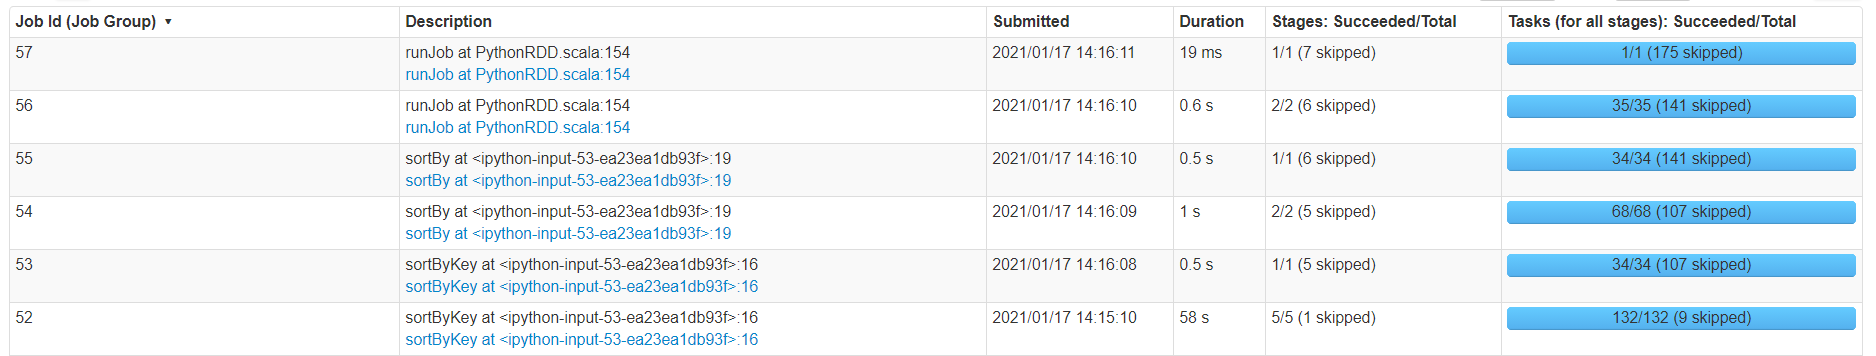

###### Stage -- 90s

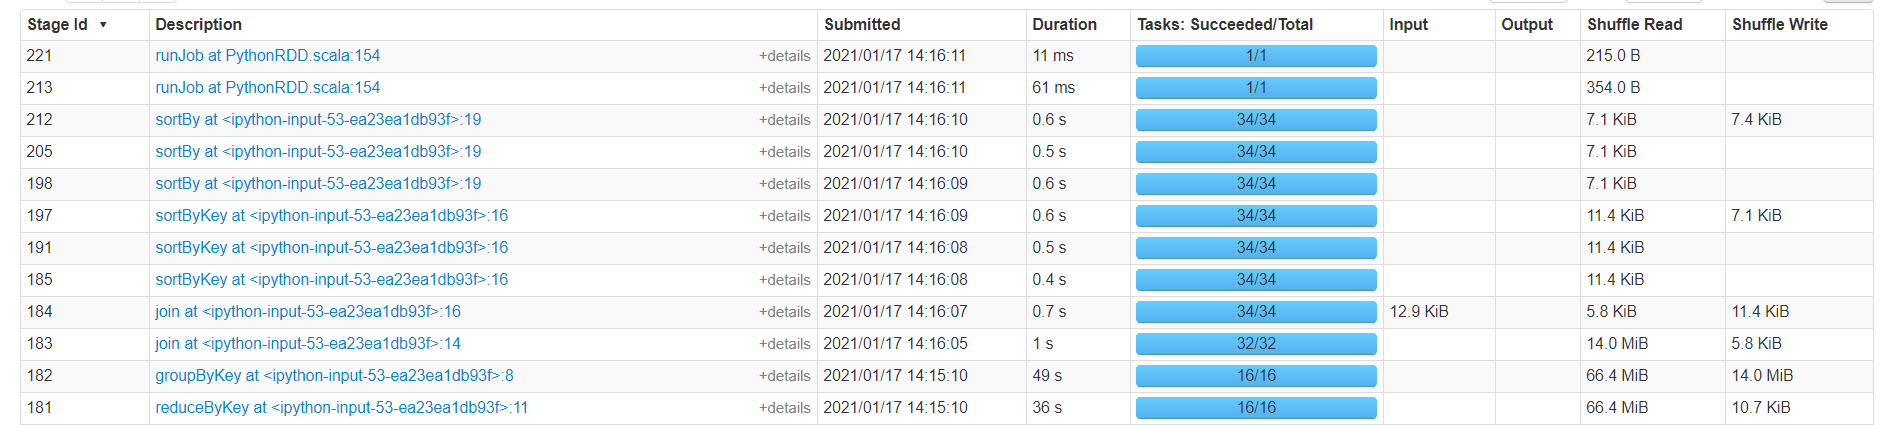

### Dataframe operation

###### Job -- 6.7s

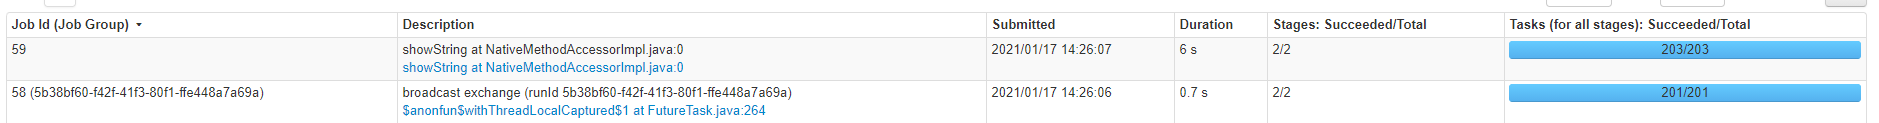

###### Stage -- 6.3s

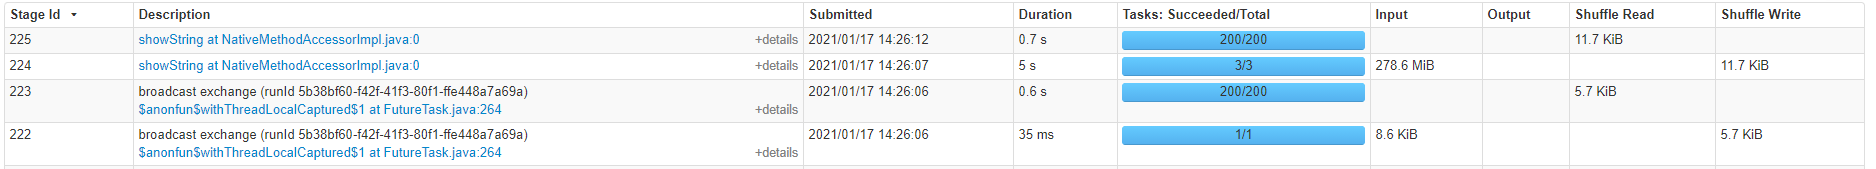

###### Task information

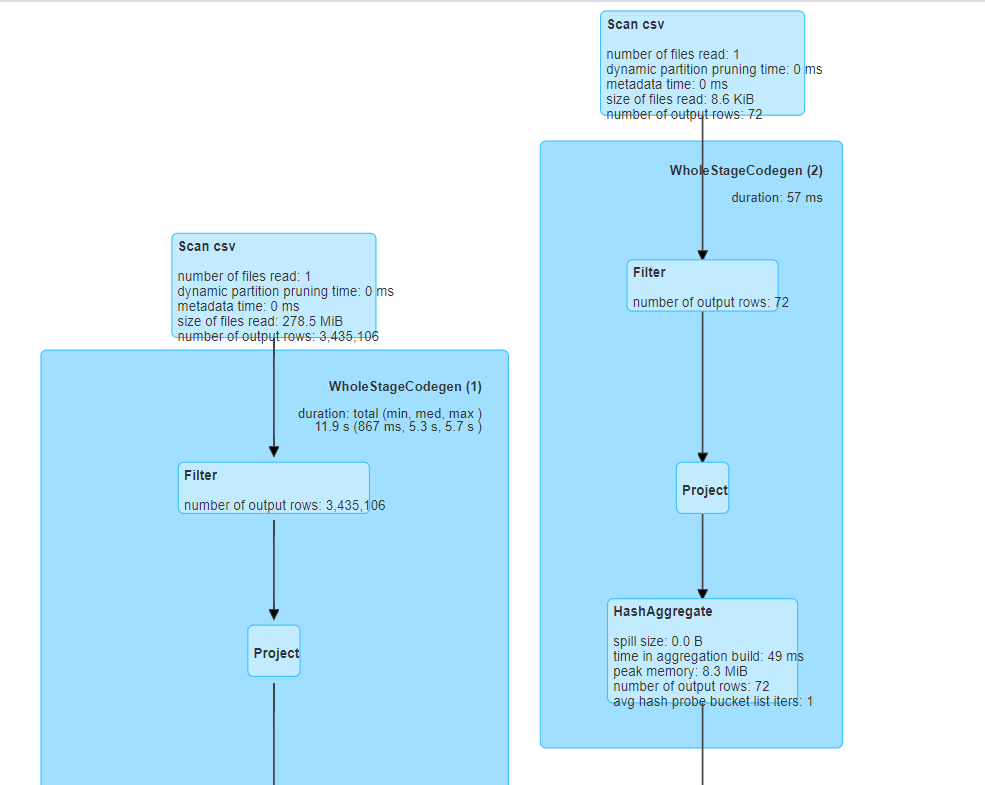

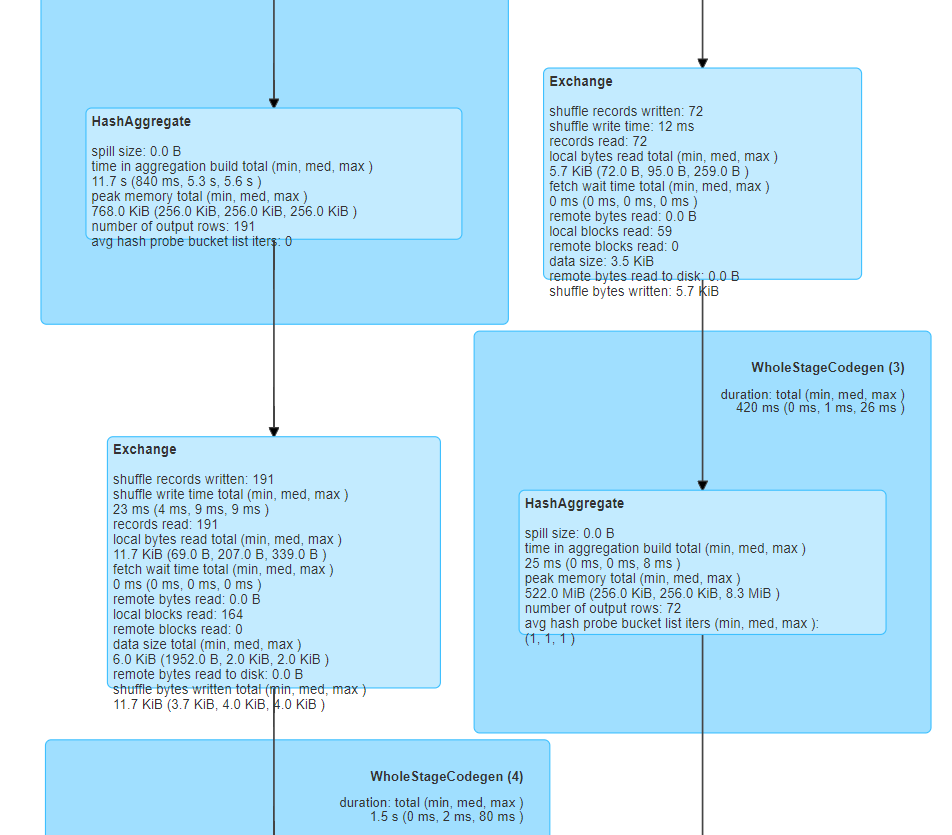

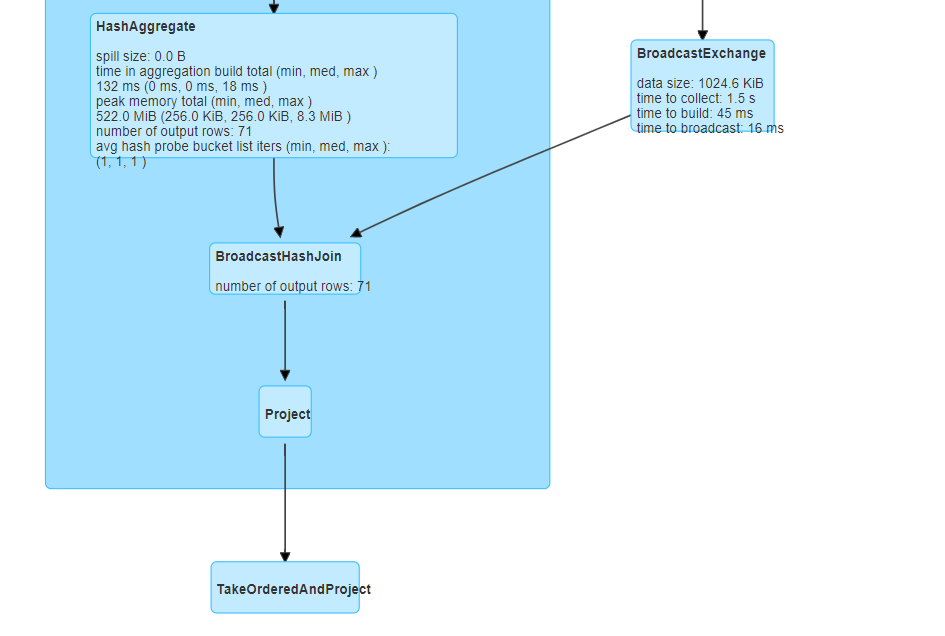

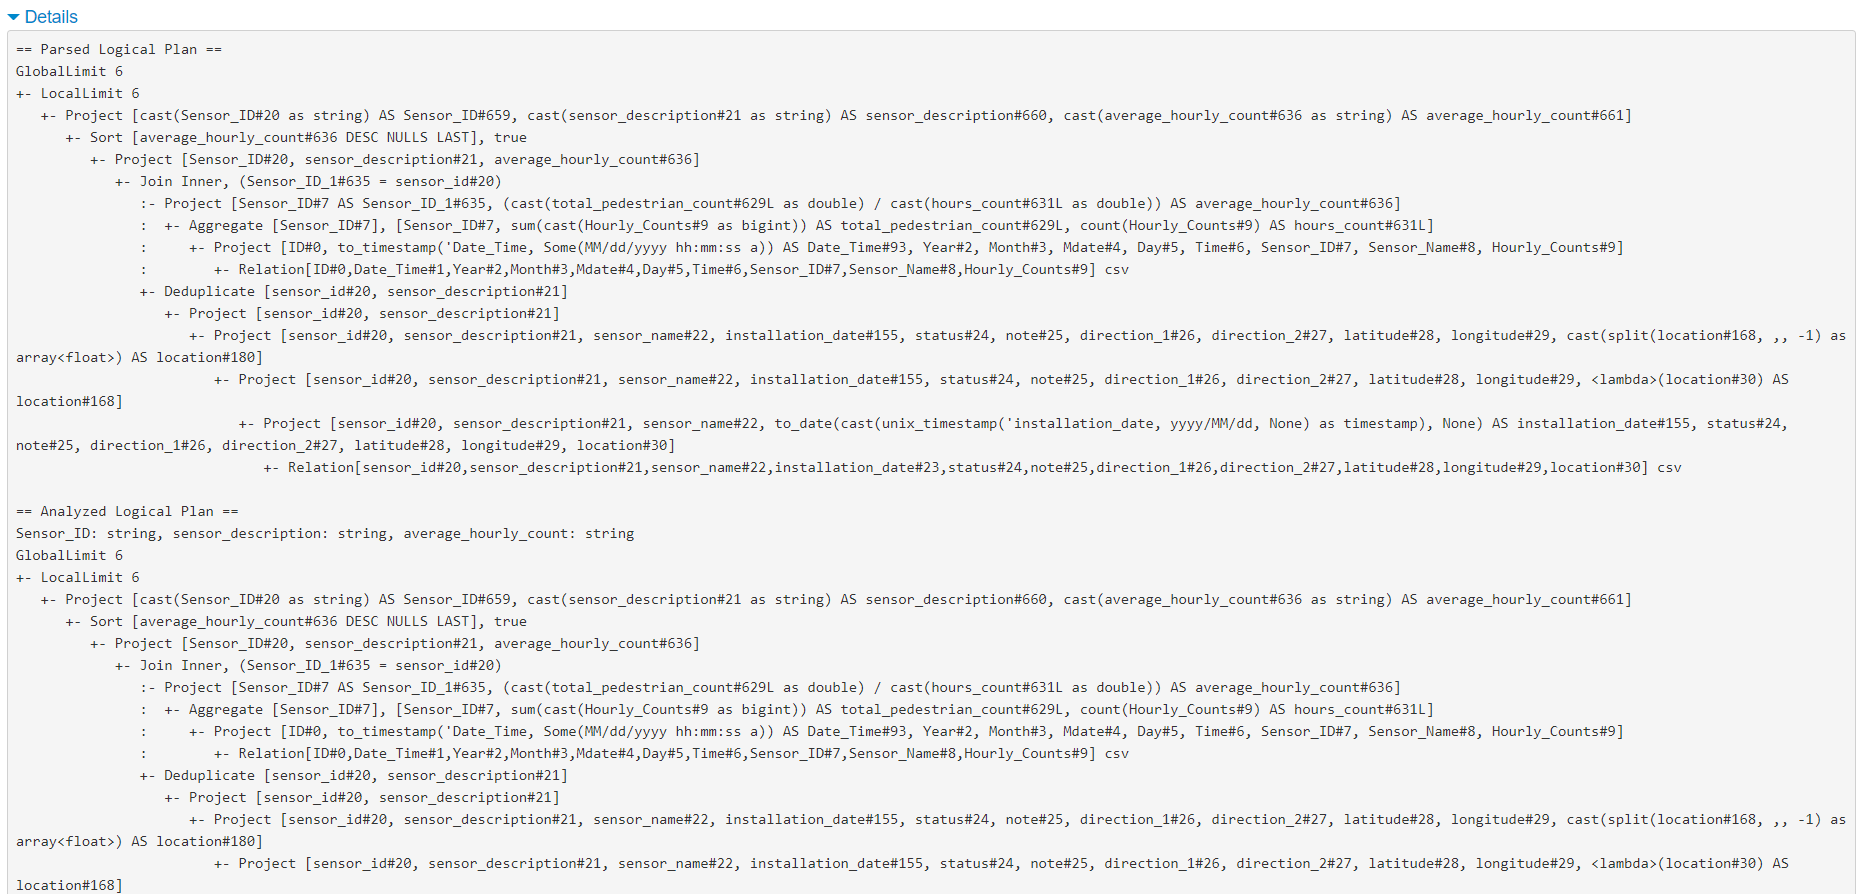

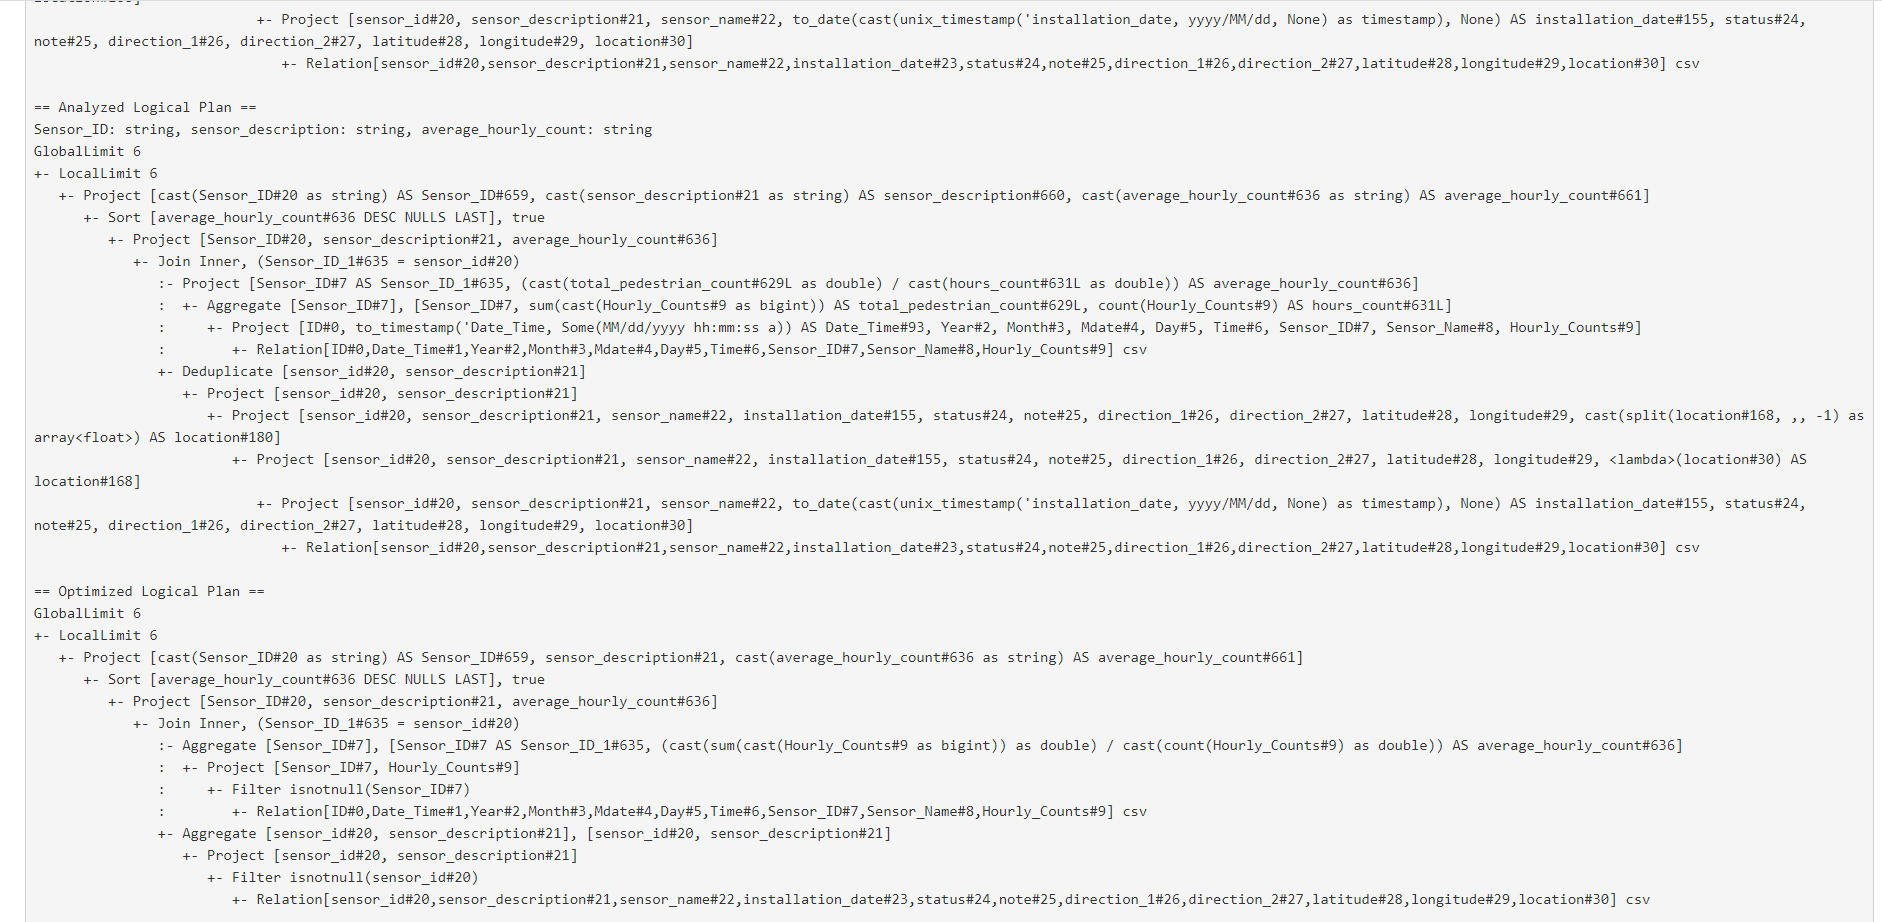

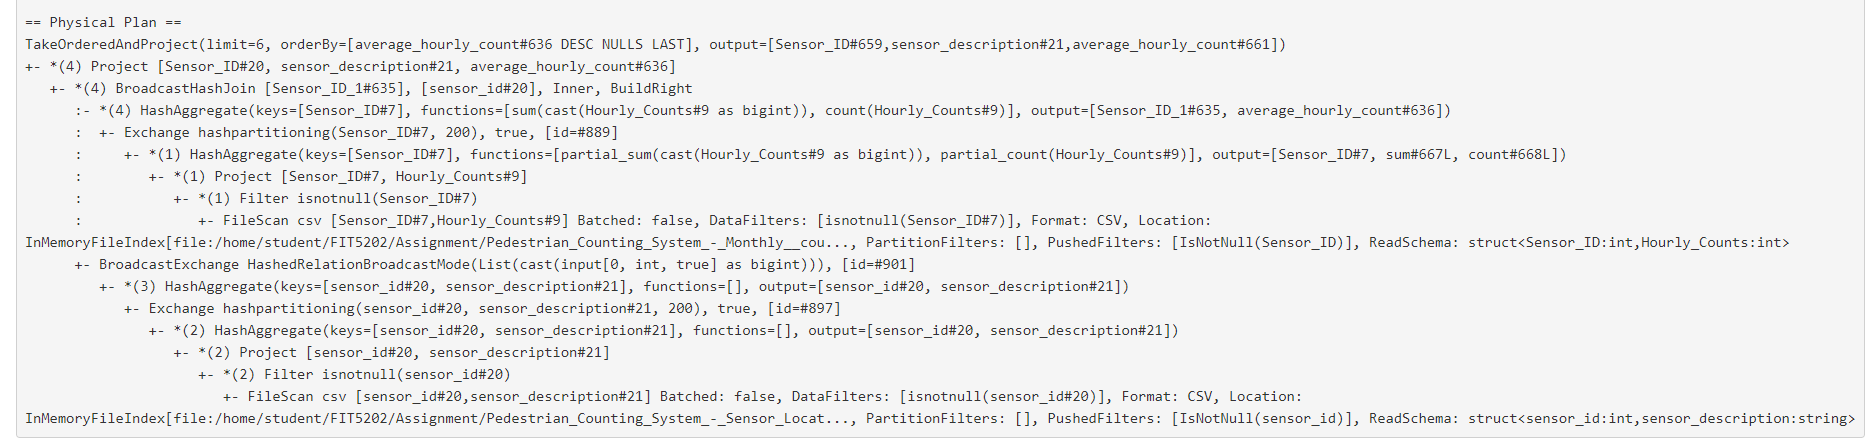

### 3.1.2 Performance Explain

RDD: 60.6s  
Dataframe:6.7s  
  
  
In this task, the time spent on the RDD approach takes more than nine times than the Dataframe approach, which means Dataframe operation is faster.  
  
DataFrame runs more efficiently than RDD because it has a specific structure to constrains the data. Because of it, Spark can apply several performance improvements while the job is running.



### 3.2 Performance improvement

#### 3.2.1 Task 2.2.4

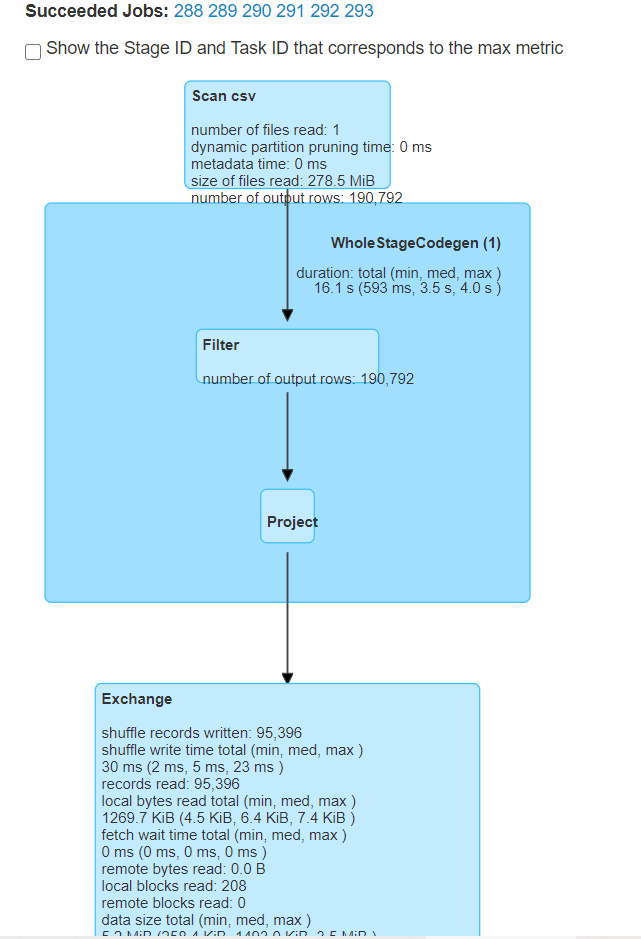

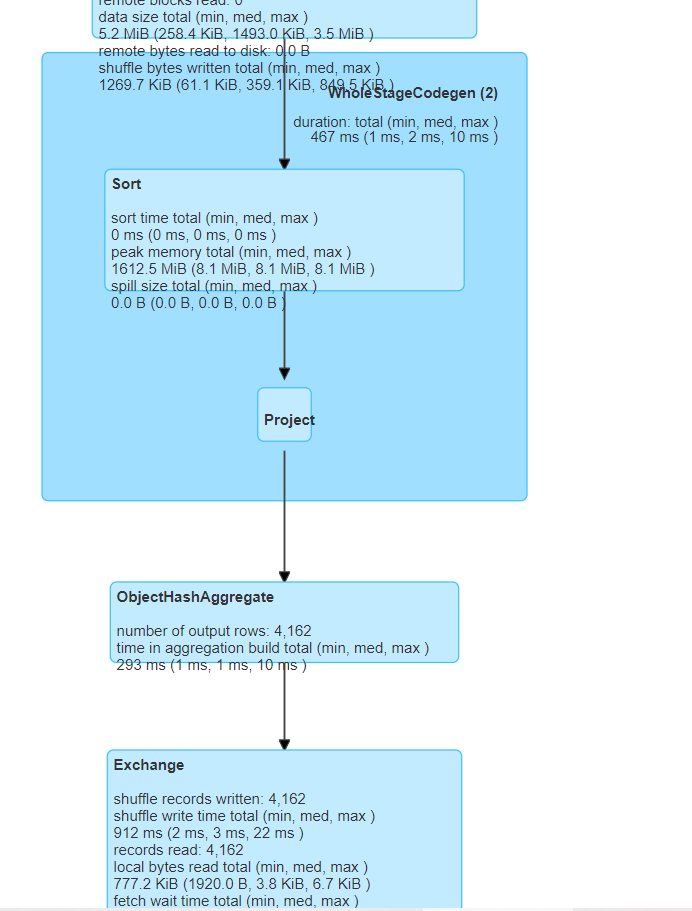

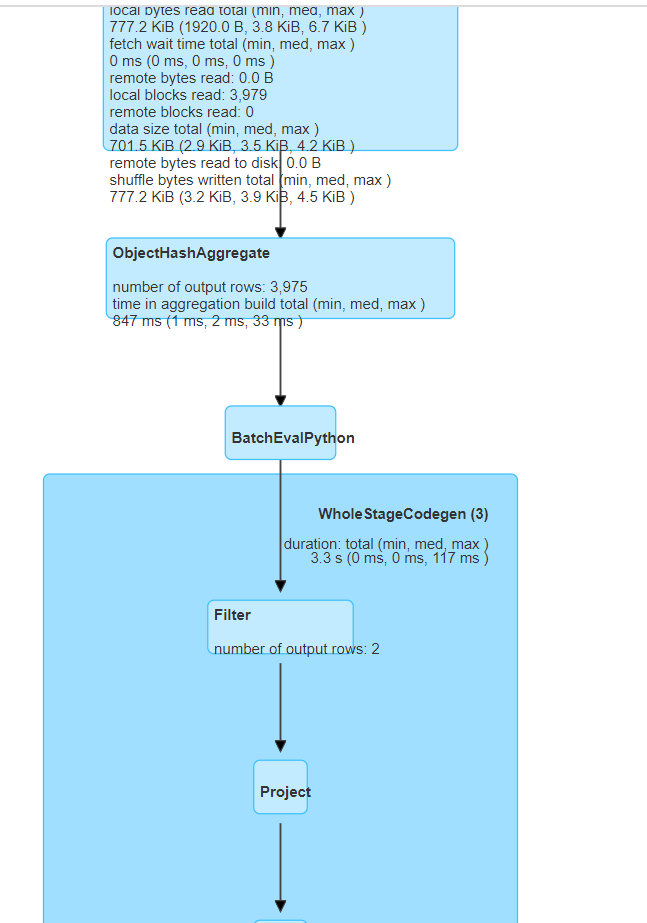

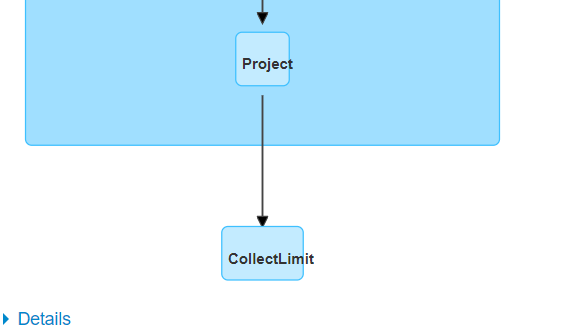

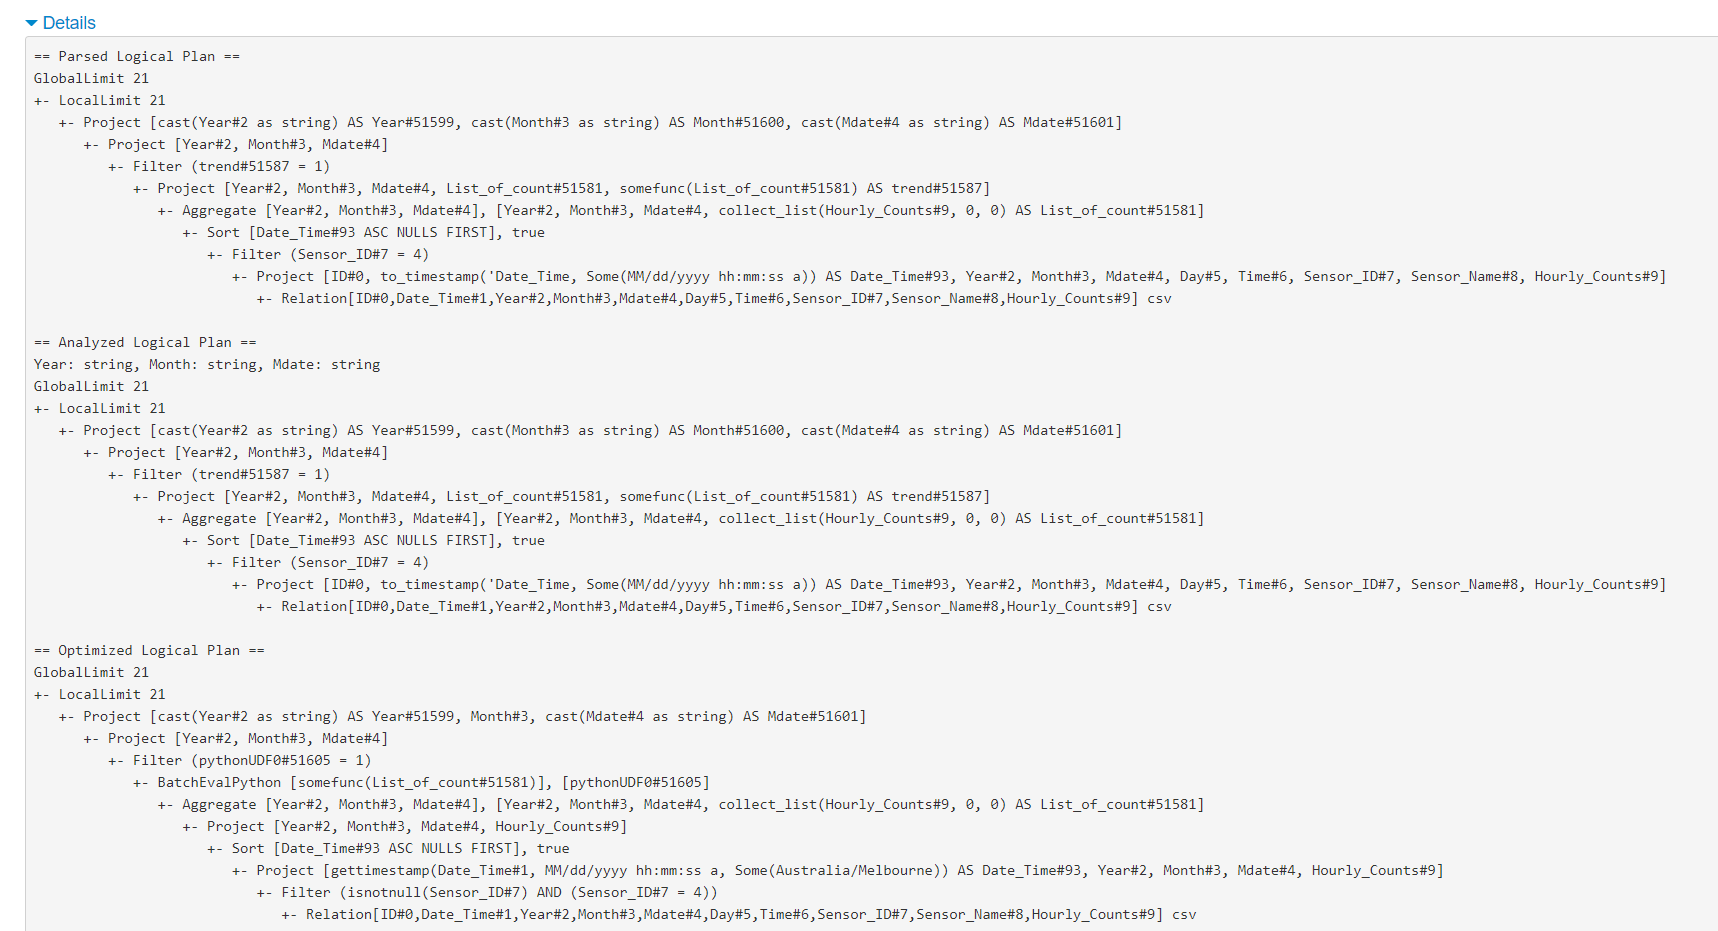

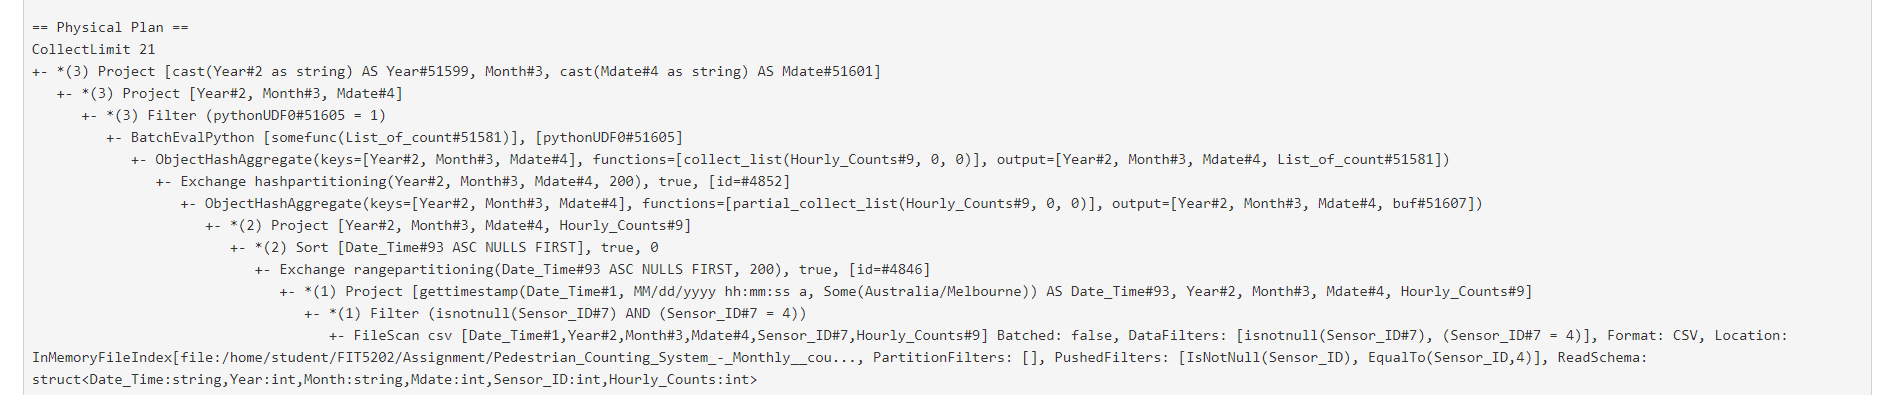

#### 3.2.2 Improve this query performance

My strategy is to extract the hourly count to save as a list and using this list to do some calculating, to get the result.
However, list operation is not efficient in this task, because we have to convert the dataframe column to a list and then convert it back to the dataframe.  
    
In this query, we can create another dataframe, and match them to get the result. This approach might improve the performance because it needn't to convert the data to other data types.

Also, we can use some physical methods to improve this query performance. For instance, using a more powerful computer to do this query.